In [1]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.utils import to_categorical
from keras.preprocessing import image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
%matplotlib inline

In [2]:
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
train = pd.read_csv('image_tagging/train.csv') # set limit, delete "nrows" to undo
train.drop(['Name'],axis=1,inplace=True)
train.drop(train[train["Key"] == "182.429"].index, inplace=True) # invalid row
train.reset_index(drop=True, inplace=True)
train.head()

,Key,Type,normal,fire,water,grass,electric,ice,fighting,poison,ground,flying,psychic,bug,rock,ghost,dragon,dark,steel,fairy
0,110.95,"poison, ground",0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0
1,155.408,"fire, fairy",0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,360.381,"grass, psychic",0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,6.142e,"fire, flying",0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4,289.175,"bug, fairy",0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1


In [4]:
train.columns

Index(['Key', 'Type', 'normal', 'fire', 'water', 'grass', 'electric', 'ice',
       'fighting', 'poison', 'ground', 'flying', 'psychic', 'bug', 'rock',
       'ghost', 'dragon', 'dark', 'steel', 'fairy'],
      dtype='object')

In [5]:
TRAINING_DATASET = "/blue/rcstudents/smaley/pokegan/customsprites/blk_bg/input"
# IMAGE_SIZE = (256,256,3)
IMAGE_SIZE = (64,64,3) # try scaling down

train_image = []
for i in tqdm(range(train.shape[0])):
    img = image.load_img(f"{TRAINING_DATASET}/{train.at[i, 'Key']}.png",target_size=IMAGE_SIZE)
    img = image.img_to_array(img)
    img = img/255
    train_image.append(img)
X = np.array(train_image)

100%|██████████| 81649/81649 [01:56<00:00, 700.41it/s]


In [12]:
from keras.models import load_model

model = load_model("64_50_epoch.keras")

In [13]:
import csv

file_path = "image_tagging/all_pokemon_to_type.csv"
pokedex = {}

with open(file_path, mode='r') as file:
    csv_reader = csv.DictReader(file)
    for row in csv_reader:
        key = row['Key']
        value = {col: row[col] for col in row if col != 'Key'}
        pokedex[key] = value

print(pokedex["338.287i"])

{'Type': 'dark, fairy', 'Name': 'Zoroark/Gardevoir', 'Body': '338', 'Head': '287'}


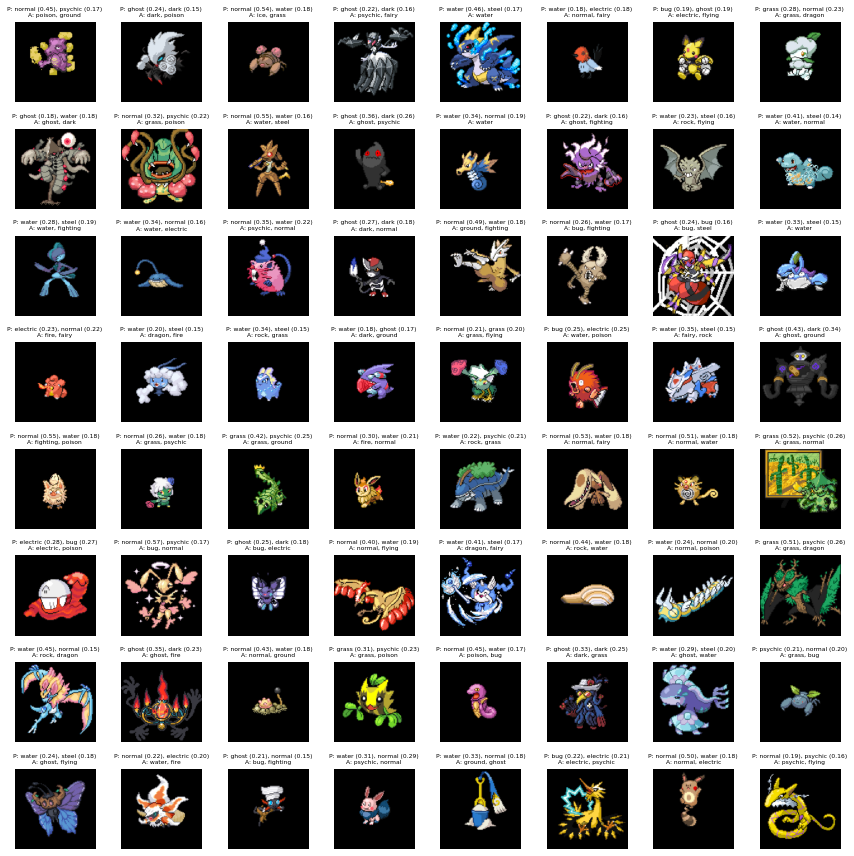

In [14]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

# Constants
GRID_SIZE = 8  # 8x8 grid
OUTPUT_FILE = "predictions_grid_4.png"  # Output file name

# Variables
count = 0
fig, axes = plt.subplots(GRID_SIZE, GRID_SIZE, figsize=(12, 12))
axes = axes.flatten()

# Iterate through the dataset
for idx, file_name in enumerate(os.listdir(TRAINING_DATASET)):
    if count >= GRID_SIZE * GRID_SIZE:  # Limit to 64 images
        break
    
    # Load and preprocess the image
    img_path = os.path.join(TRAINING_DATASET, file_name)
    img = image.load_img(img_path, target_size=IMAGE_SIZE)
    img_array = image.img_to_array(img) / 255.0  # Normalize
    classes = np.array(train.columns[2:])
    
    # Make predictions
    proba = model.predict(img_array.reshape(1,64,64,3))
    top_2 = np.argsort(proba[0])[:-3:-1]  # Get top 2 predictions
    top_2_predictions = [f"{classes[i]} ({proba[0][i]:.2f})" for i in top_2]
    
    # Get ground truth
    ground_truth = pokedex[file_name[:-4]]["Type"]
    
    # Plot image in grid
    axes[idx].imshow(image.load_img(img_path,target_size=(256,256,3)))
    axes[idx].axis('off')  # Turn off axis
    axes[idx].set_title(f"P: {', '.join(top_2_predictions)}\nA: {ground_truth}", fontsize=6)
    
    count += 1

# Adjust layout and save the grid
plt.tight_layout()
plt.savefig(OUTPUT_FILE, dpi=300)
plt.show()